In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as iio
from PIL import Image
import torch

import byotrack
from byotrack.implementation.detector.stardist import StarDistDetector
from byotrack.implementation.linker.icy_emht import IcyEMHTLinker
from byotrack.implementation.refiner.cleaner import Cleaner
from byotrack.implementation.refiner.stitching.emc2 import EMC2Stitcher
# from byotrack.implementation.refiner.interpolater import ForwardBackwardInterpolater

icy_path = "/home/noah/Documents/icy-2.4.2.0-all"
tifpath = './ExampleData/shortStack_adjusted/' #path to sequence of tiff files


In [8]:
def Read_Data_TIFseq(vid_path):
    # positions = (pd.read_csv(csv_path,usecols=['TrackID','t','x','y'])).values
    vid = iio.ImageCollection(vid_path + '/*.tif').concatenate() #concatonate to numpyarray
    # red_vid = iio.ImageCollection(red_vid_path + '/*.tif')
    vid = vid.reshape(vid.shape[0], vid.shape[1], vid.shape[2], 1)
    #vid = np.asarray([csbdeepNormaliser(frame) for frame in vid])
    return vid

video = Read_Data_TIFseq(tifpath)

In [49]:
#load in a detection sequence
detections_sequence = np.load('/home/noah/Documents/NoahT2022/CodeRepos/Utopia/ExampleData/shortStack_adjusted/detections.npy', allow_pickle=True)

#somehow this is plotting yx instead of xy!!!!!!!
#this is probably the same issue I was having before with open cv, one of my reshaper functions is probably wrong :)

#quick fix :
for detection_frame in detections_sequence:
    detection_frame.data = detection_frame.position.flip(1)
# detections_sequence = [detection_frame.position.flip(1) for detection_frame in detections_sequence]


In [51]:
dir(detection_sequence[0])

print(detection_sequence[0].position.flip(1))


tensor([[341.7426, 594.4257],
        [ 78.0154, 477.9692],
        [607.3692, 375.9539],
        [168.2889, 362.2222],
        [126.6454, 271.5107],
        [103.2619, 408.1429],
        [730.7476, 709.3204],
        [737.7736, 418.2264],
        [681.3594, 811.9844],
        [617.7812, 365.4219],
        [306.7733, 315.9333],
        [657.5763, 663.4068],
        [743.6411, 396.0000],
        [729.8302, 409.3773],
        [374.0000, 436.0000],
        [255.3462, 600.2115],
        [709.2090, 520.7910],
        [289.8644, 210.9661],
        [306.2414, 604.7586],
        [850.1000, 448.3800],
        [796.4000, 907.8000],
        [125.3019, 574.3962],
        [703.4832, 483.6846],
        [505.7467, 896.4533],
        [245.3457, 644.8642],
        [291.4259, 848.7037],
        [296.8361, 319.9344],
        [225.6042, 696.1771],
        [539.7903, 659.3226],
        [490.5625, 477.9844],
        [315.1887, 504.5094],
        [495.8281, 567.4688],
        [266.3333, 594.4762],
        [8

In [40]:
# Run linking

linker = IcyEMHTLinker(icy_path)
linker.motion = linker.Motion.BROWNIAN
tracklets = linker.run(video, detections_sequence) #why does the linker need the video?

AttributeError: 'Tensor' object has no attribute 'bbox'

torch.Size([20, 129, 2])


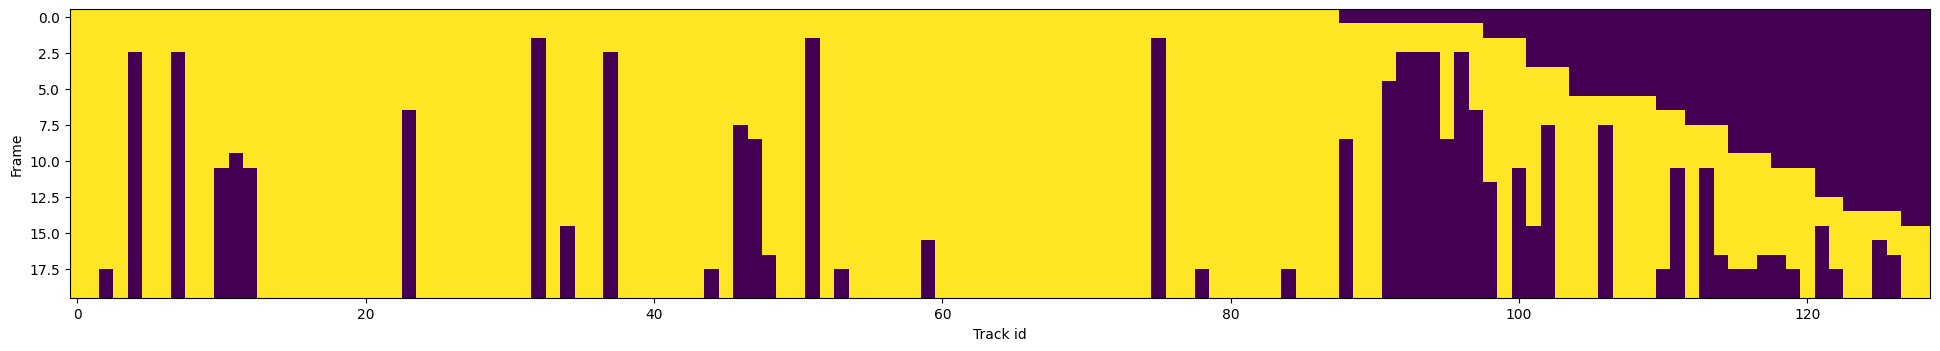

In [18]:
def display_lifetime(tracks):
    # Transform into tensor
    tracks_tensor = byotrack.Track.tensorize(tracks)
    print(tracks_tensor.shape)  # N_frame x N_track x D

    mask = ~ torch.isnan(tracks_tensor).any(dim=2)

    plt.figure(figsize=(24, 16), dpi=100)
    plt.xlabel("Track id")
    plt.ylabel("Frame")
    plt.imshow(mask)
    plt.show()
    
display_lifetime(tracklets)

In [20]:
def visualize_tracks(tracks, frame_id=0, fps=20, detections_sequence=()):
    """Interactive visualization
    
    CMDS:
        space: run/pause the video
        x/w: Move forward/backward in time
        c: Display detections
    """
    running = False
    display_detections = False

    while True:
        frame_id += running
        frame = (video[frame_id] * 255).astype(np.uint8)
        if display_detections and frame_id < len(detections_sequence):
            mask = (detections_sequence[frame_id].segmentation.numpy() != 0).astype(np.uint8) * 255
            frame = np.concatenate((mask[..., None], frame, np.zeros_like(frame)), axis=2)
        else:
            frame = np.concatenate((np.zeros_like(frame), frame, np.zeros_like(frame)), axis=2)

        # Add tracklets
        for track in tracks:
            point = track[frame_id]
            if torch.isnan(point).any():
                continue

            i, j = point.round().to(torch.int).tolist()

            color = (0, 0, 255)  # Red

            cv2.circle(frame, (j, i), 5, color)
            cv2.putText(frame, str(track.identifier % 100), (j + 4, i - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color)

        # Display the resulting frame
        cv2.imshow('Frame', frame)
        cv2.setWindowTitle('Frame', f'Frame {frame_id} / {len(video)}')

        # Press Q on keyboard to  exit
        key = cv2.waitKey(1000 // fps) & 0xFF

        if key == ord('q'):
            break

        if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
            break

        if key == ord(" "):
            running = not running

        if not running and key == ord("w"):  # Prev
            frame_id = (frame_id - 1) % len(video)

        if not running and key == ord("x"):  # Next
            frame_id = (frame_id + 1) % len(video)

        if key == ord("c"):
            display_detections = 1 - display_detections

    # Closes all the frames
    cv2.destroyAllWindows()
    
visualize_tracks(tracklets, detections_sequence=detections_sequence)

QObject::moveToThread: Current thread (0x55b679c79760) is not the object's thread (0x55b679f62220).
Cannot move to target thread (0x55b679c79760)

QObject::moveToThread: Current thread (0x55b679c79760) is not the object's thread (0x55b679f62220).
Cannot move to target thread (0x55b679c79760)

QObject::moveToThread: Current thread (0x55b679c79760) is not the object's thread (0x55b679f62220).
Cannot move to target thread (0x55b679c79760)

QObject::moveToThread: Current thread (0x55b679c79760) is not the object's thread (0x55b679f62220).
Cannot move to target thread (0x55b679c79760)

QObject::moveToThread: Current thread (0x55b679c79760) is not the object's thread (0x55b679f62220).
Cannot move to target thread (0x55b679c79760)

QObject::moveToThread: Current thread (0x55b679c79760) is not the object's thread (0x55b679f62220).
Cannot move to target thread (0x55b679c79760)

QObject::moveToThread: Current thread (0x55b679c79760) is not the object's thread (0x55b679f62220).
Cannot move to tar